In [52]:
pip install jaxlib

Note: you may need to restart the kernel to use updated packages.


In [53]:
%matplotlib notebook
import matplotlib.pyplot as plt

# just for making plots prettier
# comment out if you don't use seaborn
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy.optimize
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from stingray import Lightcurve, Powerspectrum

In [54]:
def powerlaw(freq, a, b):
    """
    A power law function. 
    
    Parameters
    ----------
    
    freq : iterable
        A list of frequencies for which to compute the power law.
        
    a : float
        The power law index
        
    b : float
        The normalization of the power law

    Returns
    -------
    mp : numpy.ndarray
        An array of model powers
    """
    freq = jnp.array(freq)
    log_mp = -a * jnp.log(freq) + jnp.log(b)
    
    return jnp.exp(log_mp)

def lorentzian(freq, amp, f0, width):
    """
    A Lorentzian function (Cauchy distribution in statistics). Used to 
    model quasi-periodic signals. 
    
    Parameters
    ----------
    freq : iterable
        A list of frequencies for which to compute the power law.

    amp : float
        The amplitude (height) of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    width : float 
        The width of the Lorentzian
        
    Returns
    -------
    mp : iterable
        An array of model powers
        
    """
    
    freq = jnp.array(freq)
    w_sq = width ** 2.
    nom = amp * w_sq
    denom = w_sq + (freq - f0)**2.
    
    return nom/denom


In [55]:
def model(freq, a, b, amp, f0, width, const):
    """
    A model for a periodogram with a power law, a 
    quasi-periodic oscillation (QPO) and a constant. 
    
    Parameters
    ----------
    freq : iterable
        A list of frequencies for which to compute the power law.
        
    a : float
        The power law index
        
    b : float
        The normalization of the power law

    amp : float
        The amplitude (height) of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    width : float 
        The width of the Lorentzian 

    Returns
    -------
    mp : iterable
        An array of model powers
        
    """
    mp = powerlaw(freq, a, b) +  \
          lorentzian(freq, amp, f0, width) + \
          const
            
    return mp

In [56]:
true_a = 2.5
true_b = 50.0
true_amp = 500.0
true_f0 = 2.0
true_width = 0.1
true_const = 2.0

fmin = 0.1
fmax = 30.0
nfreq = int(fmax/fmin)

freq = jnp.linspace(fmin, fmax, nfreq)
true_power = model(freq, true_a, true_b, true_amp, true_f0, true_width, true_const)

<IPython.core.display.Javascript object>


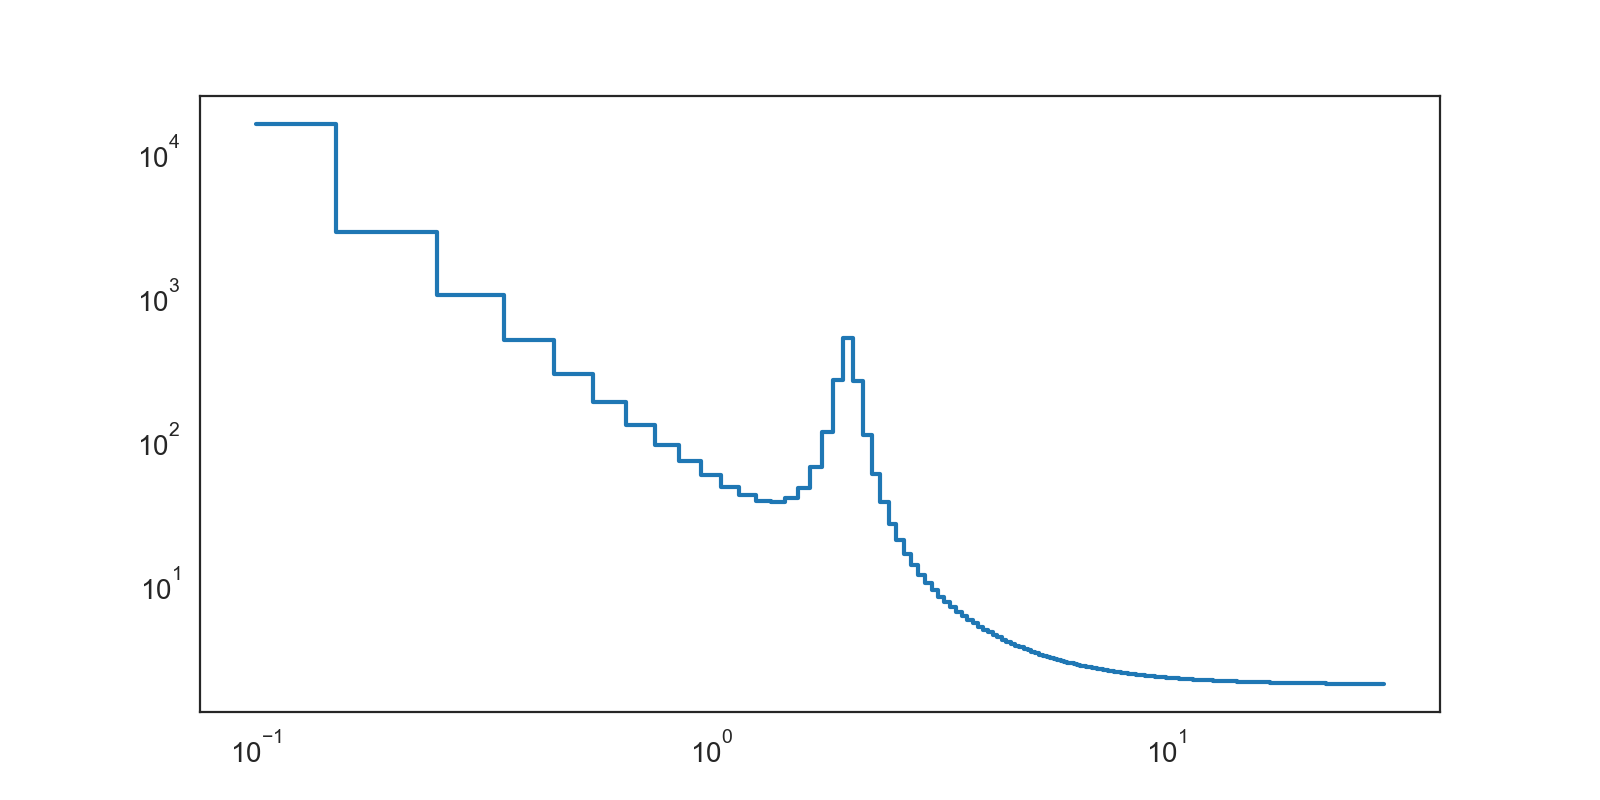

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, true_power, ds="steps-mid")

In [58]:
np.random.seed(150)
power = true_power * np.random.chisquare(2, size=true_power.shape[0])/2.0

<IPython.core.display.Javascript object>


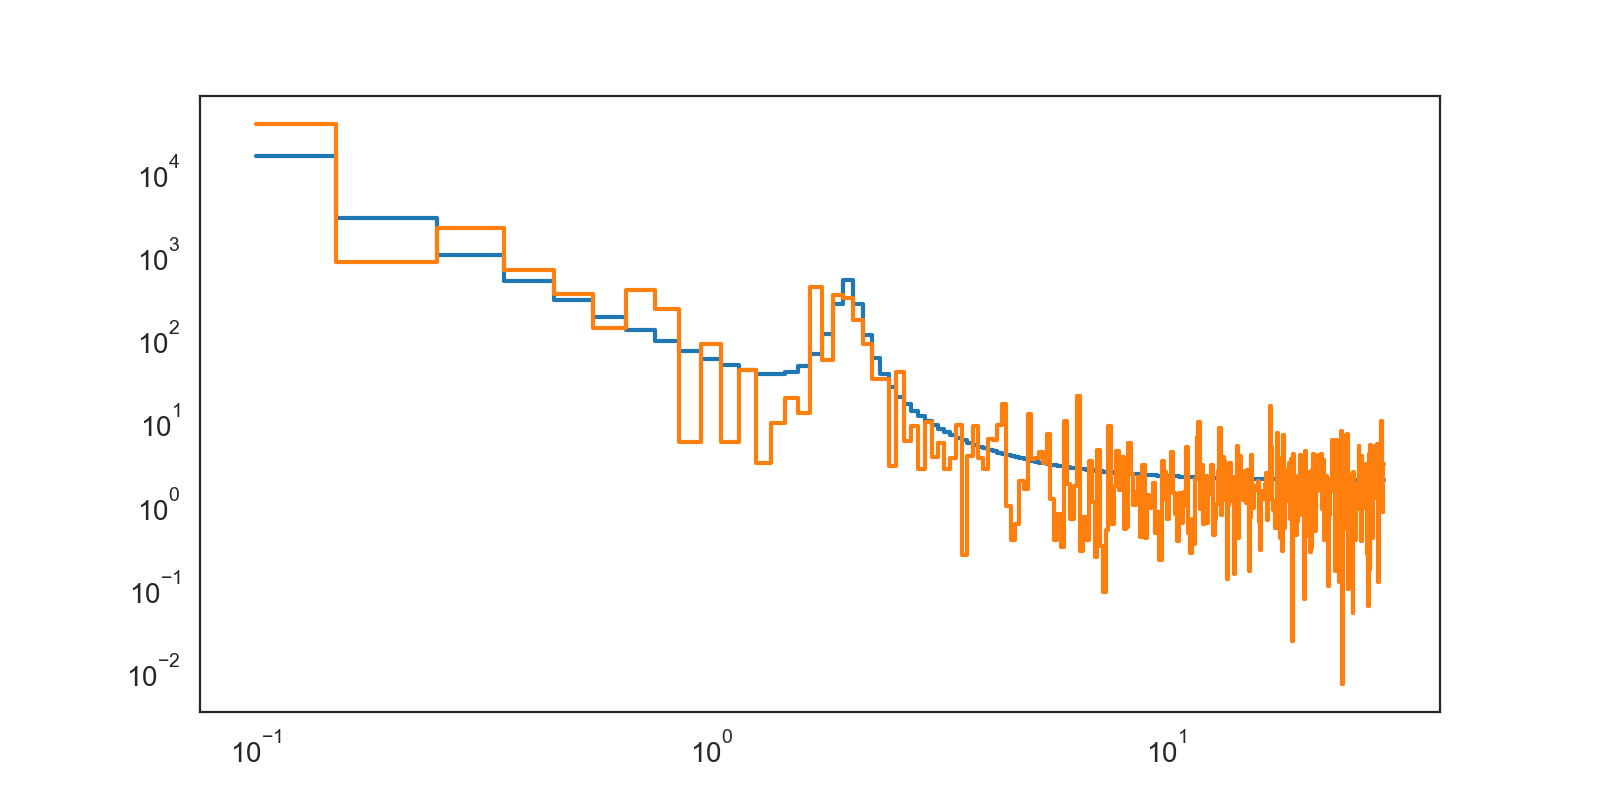

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, true_power, ds="steps-mid")
ax.loglog(freq, power, ds="steps-mid")

In [60]:
def loglikelihood(params):
    """
    Calculate a chi-square log-likelihood for a 
    periodogram and a model with a power law, a Lorentzian 
    and a constant.
    
    Note that right now, the arrays `freq` and `power` are 
    not passed in explicitly, which might cause namespace
    issues. 
    
    Parameters
    ----------
    params : iterable
        A list of parameters for the power law, Lorentzian and 
        constant model components. 
        params = [pl_index, pl_amp, lor_amp, lor_f0, lor_width, const]
        
    Returns
    -------
    loglike : numpy.ndarray
        An array with log-likelihood values.
    """
    # Calculate the model power spectrum given the parameters
    mp = model(freq, *params)
    
    # Calculate the chi-square log-likelihood
    m = 1 # right now, we're just looking at single periodograms
    loglike = -2.0*m*(jnp.sum(jnp.log(mp)) +
                            jnp.sum(power/mp) +
                            jnp.sum((2.0 / (2. * m) - 1.0) *
                            jnp.log(power)))

    return loglike

In [61]:
true_params = [true_a, true_b, true_amp, true_f0, true_width, true_const]
loglikelihood(true_params)

DeviceArray(-1348.1854, dtype=float32)

In [62]:
true_params

[2.5, 50.0, 500.0, 2.0, 0.1, 2.0]

In [63]:
test_params = [2.2, 300, 10000, 2.5, 0.1, 2.1]

loglikelihood(test_params)

DeviceArray(-1597.199, dtype=float32)

In [64]:
def objective_function(params):
    return -loglikelihood(params)

In [65]:
start_pars = [1.0, 40, 1000, 3.0, 0.5, 2.5]

In [66]:
res = scipy.optimize.minimize(objective_function, test_params, method="Nelder-Mead")

In [67]:
res

 final_simplex: (array([[2.71280260e+00, 5.74381306e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381303e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381303e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381305e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381305e+01, 2.14494015e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280259e+00, 5.74381302e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861845e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381305e+01, 2.14494015e+04, 1.77632772e+00,
        1.61861843e-02, 2.11434903e+00]]), array([1354.19189453, 1354.19189453, 1354.19189453, 1354.19189453,
       1354.19189453, 1354.19189453, 1354.19189453]))
           fun: 1354.19189453125
       message: 'Optimization termin

In [68]:
res.x - true_params

array([ 2.12802600e-01,  7.43813059e+00,  2.09494016e+04, -2.23672285e-01,
       -8.38138156e-02,  1.14349032e-01])

In [69]:
(res.x - true_params) / true_params

array([ 0.08512104,  0.14876261, 41.89880313, -0.11183614, -0.83813816,
        0.05717452])

In [70]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


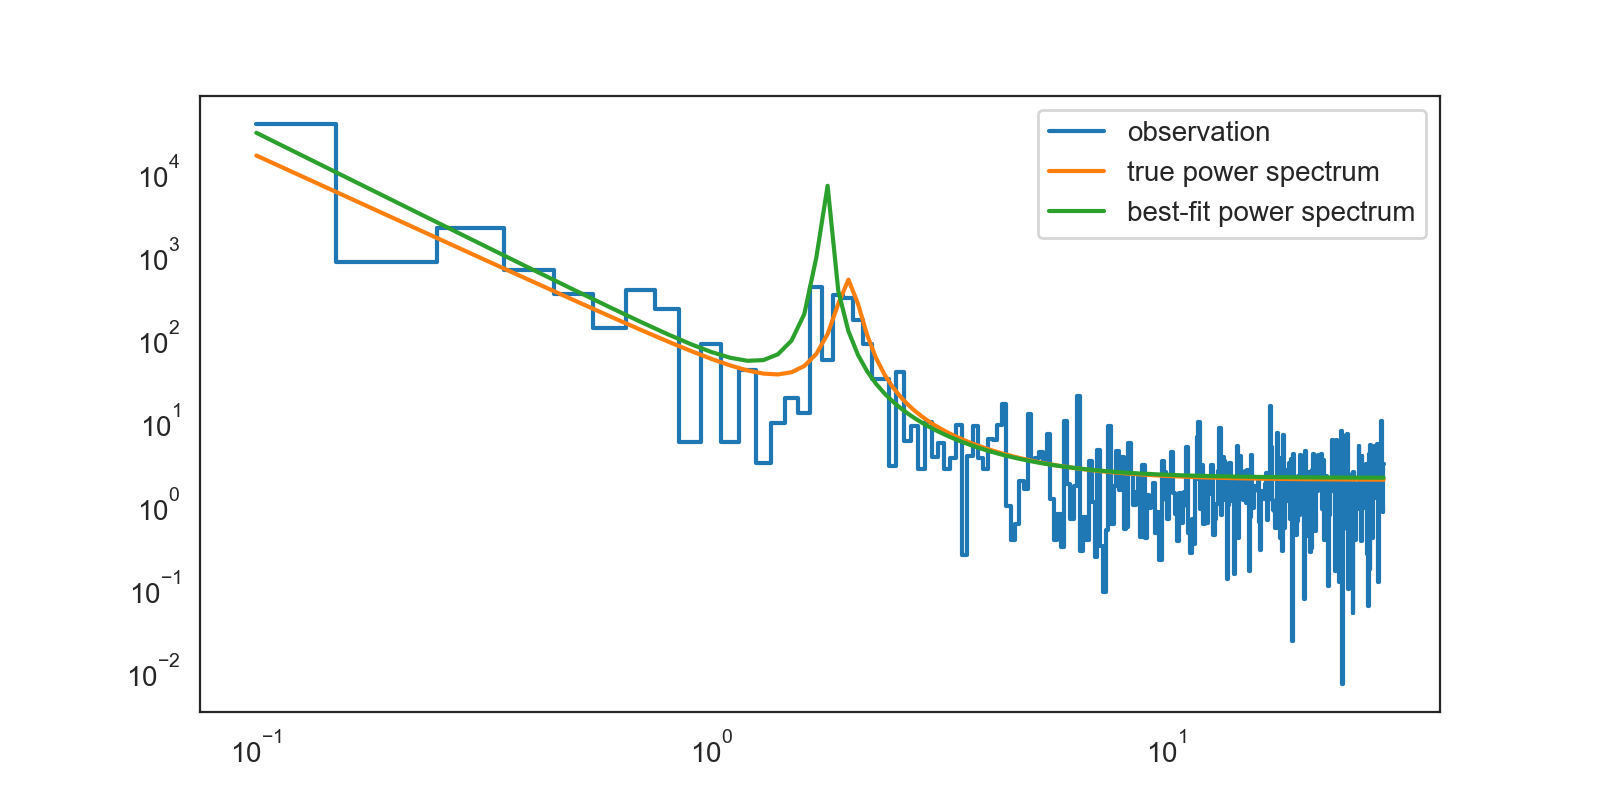

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

To test after reducing the amplitude

(i) decrease the amplitude of test-params from 10000 to 10 and check if the function fails

In [72]:
test_params = [2.2, 300, 0.8, 2.5, 0.1, 2.1]

loglikelihood(test_params)

DeviceArray(-1437.6156, dtype=float32)

In [73]:
def objective_function(params):
    return -loglikelihood(params)

In [74]:
start_pars = [1.0, 40, 1000, 3.0, 0.5, 2.5]

In [75]:
res = scipy.optimize.minimize(objective_function, test_params, method="Nelder-Mead")

In [76]:
res

 final_simplex: (array([[2.59261072e+00, 2.21247744e+02, 9.13152824e-01, 2.58420804e+00,
        9.79033946e-02, 1.95597418e+00],
       [2.59261072e+00, 2.21247744e+02, 9.13152826e-01, 2.58420804e+00,
        9.79033946e-02, 1.95597418e+00],
       [2.59261072e+00, 2.21247744e+02, 9.13152825e-01, 2.58420804e+00,
        9.79033947e-02, 1.95597418e+00],
       [2.59261072e+00, 2.21247744e+02, 9.13152826e-01, 2.58420804e+00,
        9.79033946e-02, 1.95597418e+00],
       [2.59261072e+00, 2.21247744e+02, 9.13152826e-01, 2.58420803e+00,
        9.79033946e-02, 1.95597418e+00],
       [2.59261072e+00, 2.21247744e+02, 9.13152827e-01, 2.58420804e+00,
        9.79033945e-02, 1.95597418e+00],
       [2.59261072e+00, 2.21247744e+02, 9.13152827e-01, 2.58420804e+00,
        9.79033945e-02, 1.95597418e+00]]), array([1397.13330078, 1397.13330078, 1397.13330078, 1397.13330078,
       1397.13330078, 1397.13330078, 1397.13330078]))
           fun: 1397.13330078125
       message: 'Optimization termin

In [102]:
res.x

array([2.71280260e+00, 5.74381306e+01, 2.14494016e+04, 1.77632772e+00,
       1.61861844e-02, 2.11434903e+00])

In [89]:
res.x - true_params

array([ 2.12802600e-01,  7.43813059e+00,  2.09494016e+04, -2.23672285e-01,
       -8.38138156e-02,  1.14349032e-01])

In [90]:
(res.x - true_params) / true_params

array([ 0.08512104,  0.14876261, 41.89880313, -0.11183614, -0.83813816,
        0.05717452])

In [91]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


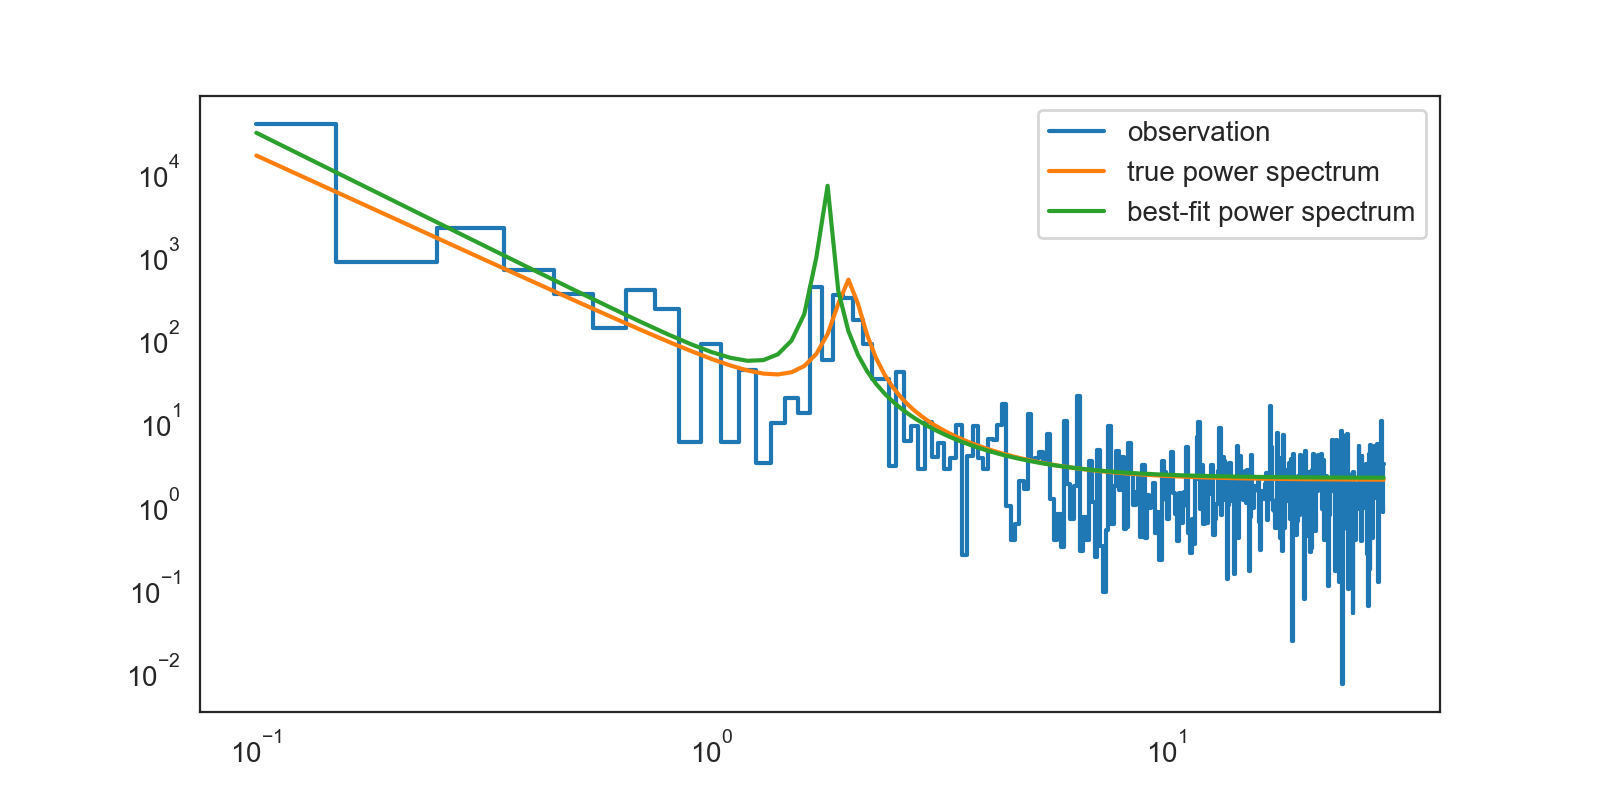

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

RESULT: By decreasing the amp of test_params the current algorithm is robust till amplitude value is [10000, 1] . As soon as we decrease the amplitude value below 1, the algorithm fails. We see the above graph for test_amp = 0.8.
Similarily, now let us change the value of start_amp from [10000] to [0.8]

In [93]:
test_params = [2.2, 300, 10000, 2.5, 0.1, 2.1]

loglikelihood(test_params)

DeviceArray(-1597.199, dtype=float32)

In [94]:
def objective_function(params):
    return -loglikelihood(params)

In [95]:
start_pars = [1.0, 40, 0.9, 3.0, 0.5, 2.5]

In [96]:
res = scipy.optimize.minimize(objective_function, test_params, method="Nelder-Mead")

In [97]:
res

 final_simplex: (array([[2.71280260e+00, 5.74381306e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381303e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381303e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381305e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381305e+01, 2.14494015e+04, 1.77632772e+00,
        1.61861844e-02, 2.11434903e+00],
       [2.71280259e+00, 5.74381302e+01, 2.14494016e+04, 1.77632772e+00,
        1.61861845e-02, 2.11434903e+00],
       [2.71280260e+00, 5.74381305e+01, 2.14494015e+04, 1.77632772e+00,
        1.61861843e-02, 2.11434903e+00]]), array([1354.19189453, 1354.19189453, 1354.19189453, 1354.19189453,
       1354.19189453, 1354.19189453, 1354.19189453]))
           fun: 1354.19189453125
       message: 'Optimization termin

In [98]:
type(true_params)

list

In [99]:
type(res.x)

numpy.ndarray

In [105]:
(res.x - true_params) / true_params

array([ 0.08512104,  0.14876261, 41.89880313, -0.11183614, -0.83813816,
        0.05717452])

In [106]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


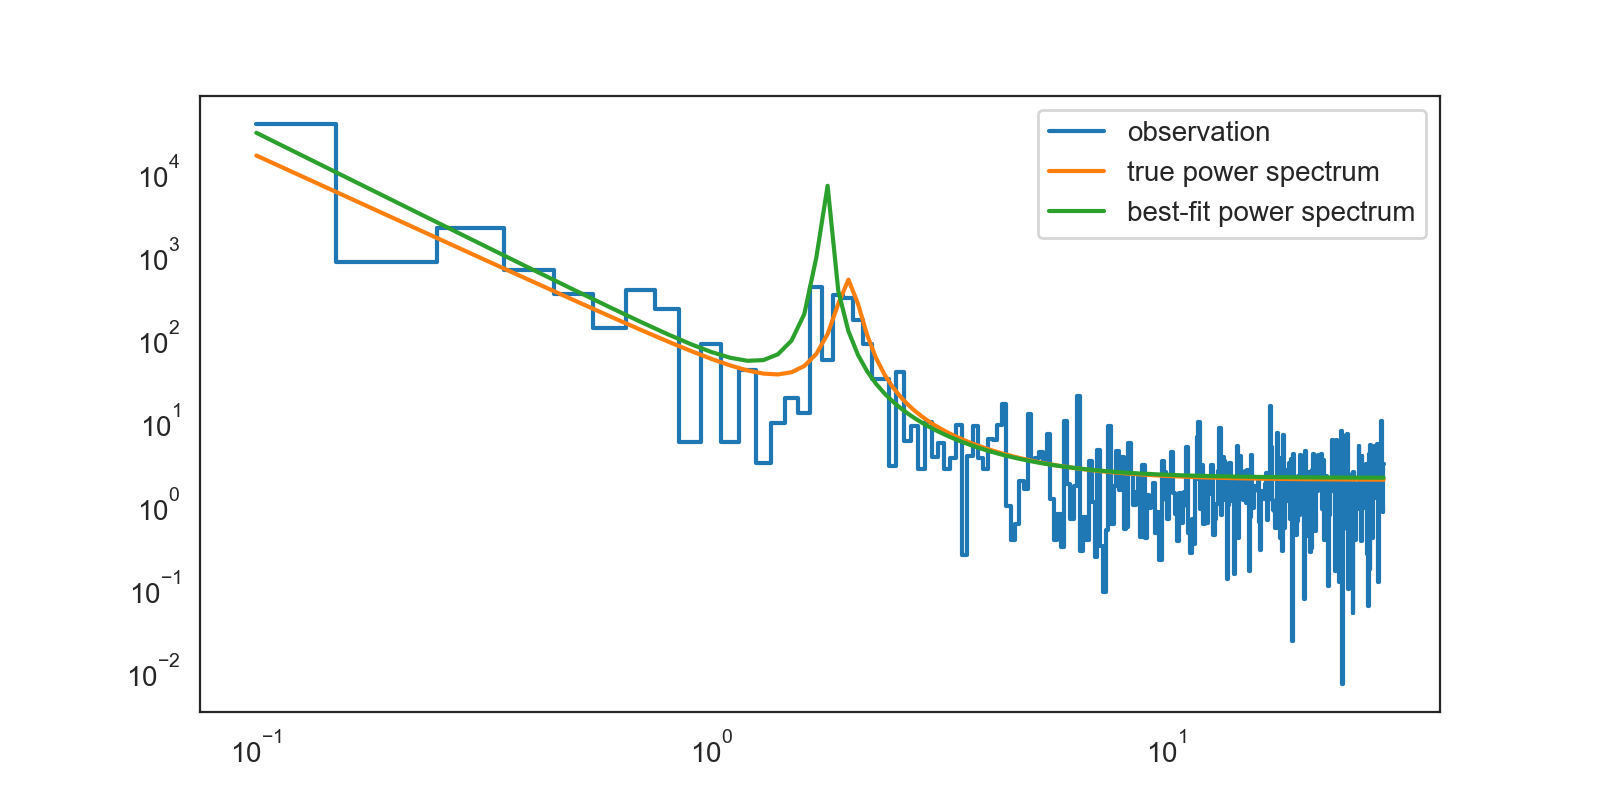

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

RESULT: The algorithm works fine for all values of start amplitude even when it drops less than 1.

(ii)start the optimization with values far away from true parameters

In [149]:
start_pars = [0.1, 0.440, 0.034, 0.003, 0.01, 25000]

In [160]:
test_params = [.2, 30, 100, 0.5, 0.2, 0.21]

loglikelihood(test_params)

DeviceArray(-3191.2812, dtype=float32)

In [161]:
res = scipy.optimize.minimize(objective_function, test_params, method="Nelder-Mead")

In [162]:
res

 final_simplex: (array([[-3.92624406e-01,  2.27225946e+00,  4.52835065e+03,
         7.54423193e-02,  1.94560718e-01, -5.67990916e+00],
       [-4.00693674e-01,  2.21255571e+00,  4.52092112e+03,
         7.80879368e-02,  1.95007438e-01, -5.65598416e+00],
       [-4.06153866e-01,  2.10567155e+00,  4.36691019e+03,
         8.99885737e-02,  1.97983768e-01, -5.42176358e+00],
       [-4.14263743e-01,  2.12192242e+00,  4.48018781e+03,
         7.49662820e-02,  1.97246292e-01, -5.57548957e+00],
       [-4.06728607e-01,  2.09199066e+00,  4.34250178e+03,
         7.74753592e-02,  1.98062009e-01, -5.38172279e+00],
       [-4.13114172e-01,  2.04440250e+00,  4.26714464e+03,
         8.70412585e-02,  1.98093008e-01, -5.26538775e+00],
       [-4.21131115e-01,  2.02240357e+00,  4.39354021e+03,
         7.61556969e-02,  2.02485916e-01, -5.43537165e+00]]), array([1398.28527832, 1398.57373047, 1398.70300293, 1398.71459961,
       1398.76635742, 1398.81970215, 1398.91052246]))
           fun: 1398.285278

In [163]:
res.x - true_params

array([-2.89262441e+00,  1.27225946e+00,  4.02835065e+03, -1.92455768e+00,
        9.45607176e-02, -7.67990916e+00])

In [164]:
(res.x - true_params) / true_params

array([-1.15704976,  1.27225946,  8.05670129, -0.96227884,  0.94560718,
       -3.83995458])

In [165]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


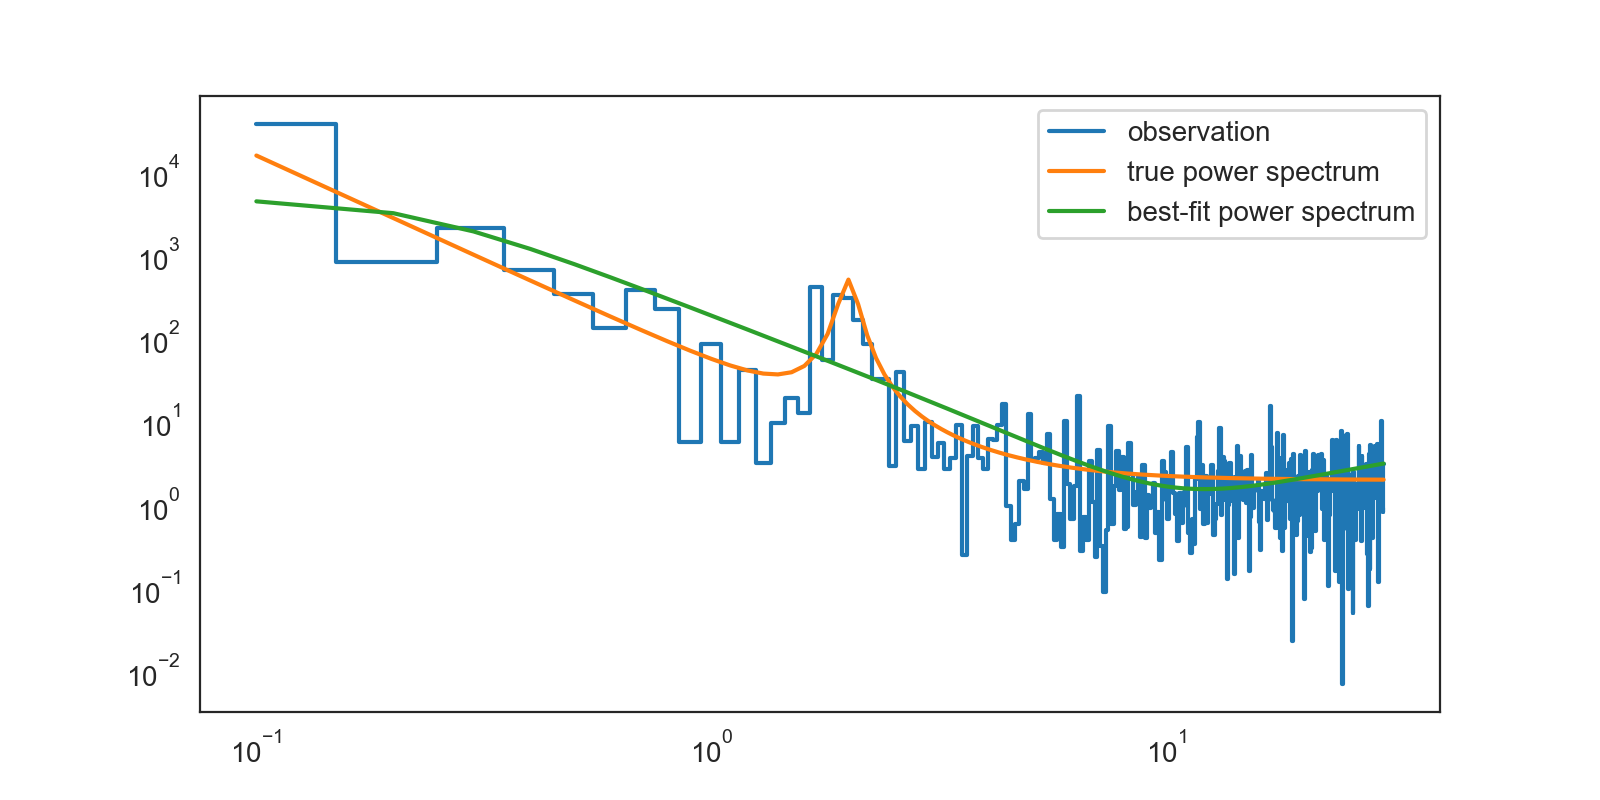

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

Result: If we start from a value of test parameters = [.2, 30, 100, 0.5, 0.2, 0.21] which is far away from true_parameters, then the algorithm fails.
However, changing the start parameters didn't affect the fit.

Let us try another set of test parameters = [2.0, 30, 10000, 0.25, 0.01, 2.1]

In [177]:
test_params = [2.2, 300, 10000, .25, 0.01, 2.1]

loglikelihood(test_params)

DeviceArray(-1438.217, dtype=float32)

In [178]:
res = scipy.optimize.minimize(objective_function, test_params, method="Nelder-Mead")

In [179]:
res

 final_simplex: (array([[2.59530952e+00, 2.22589646e+02, 1.02164080e+04, 2.82539794e-01,
        8.70442516e-05, 1.95673069e+00],
       [2.59530952e+00, 2.22589647e+02, 1.02164079e+04, 2.82539798e-01,
        8.70438149e-05, 1.95673069e+00],
       [2.59530952e+00, 2.22589646e+02, 1.02164080e+04, 2.82539794e-01,
        8.70437922e-05, 1.95673068e+00],
       [2.59530952e+00, 2.22589646e+02, 1.02164080e+04, 2.82539796e-01,
        8.70442098e-05, 1.95673068e+00],
       [2.59530951e+00, 2.22589645e+02, 1.02164080e+04, 2.82539796e-01,
        8.70439781e-05, 1.95673068e+00],
       [2.59530952e+00, 2.22589646e+02, 1.02164079e+04, 2.82539798e-01,
        8.70439184e-05, 1.95673069e+00],
       [2.59530952e+00, 2.22589646e+02, 1.02164079e+04, 2.82539796e-01,
        8.70441314e-05, 1.95673069e+00]]), array([1397.14135742, 1397.14135742, 1397.14135742, 1397.14135742,
       1397.14135742, 1397.14135742, 1397.14135742]))
           fun: 1397.141357421875
       message: 'Optimization termi

In [180]:
res.x - true_params

array([ 9.53095216e-02,  2.21589646e+02,  9.71640795e+03, -1.71746021e+00,
       -9.99129557e-02, -4.32693125e-02])

In [181]:
(res.x - true_params) / true_params

array([ 3.81238086e-02,  2.21589646e+02,  1.94328159e+01, -8.58730103e-01,
       -9.99129557e-01, -2.16346563e-02])

In [182]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


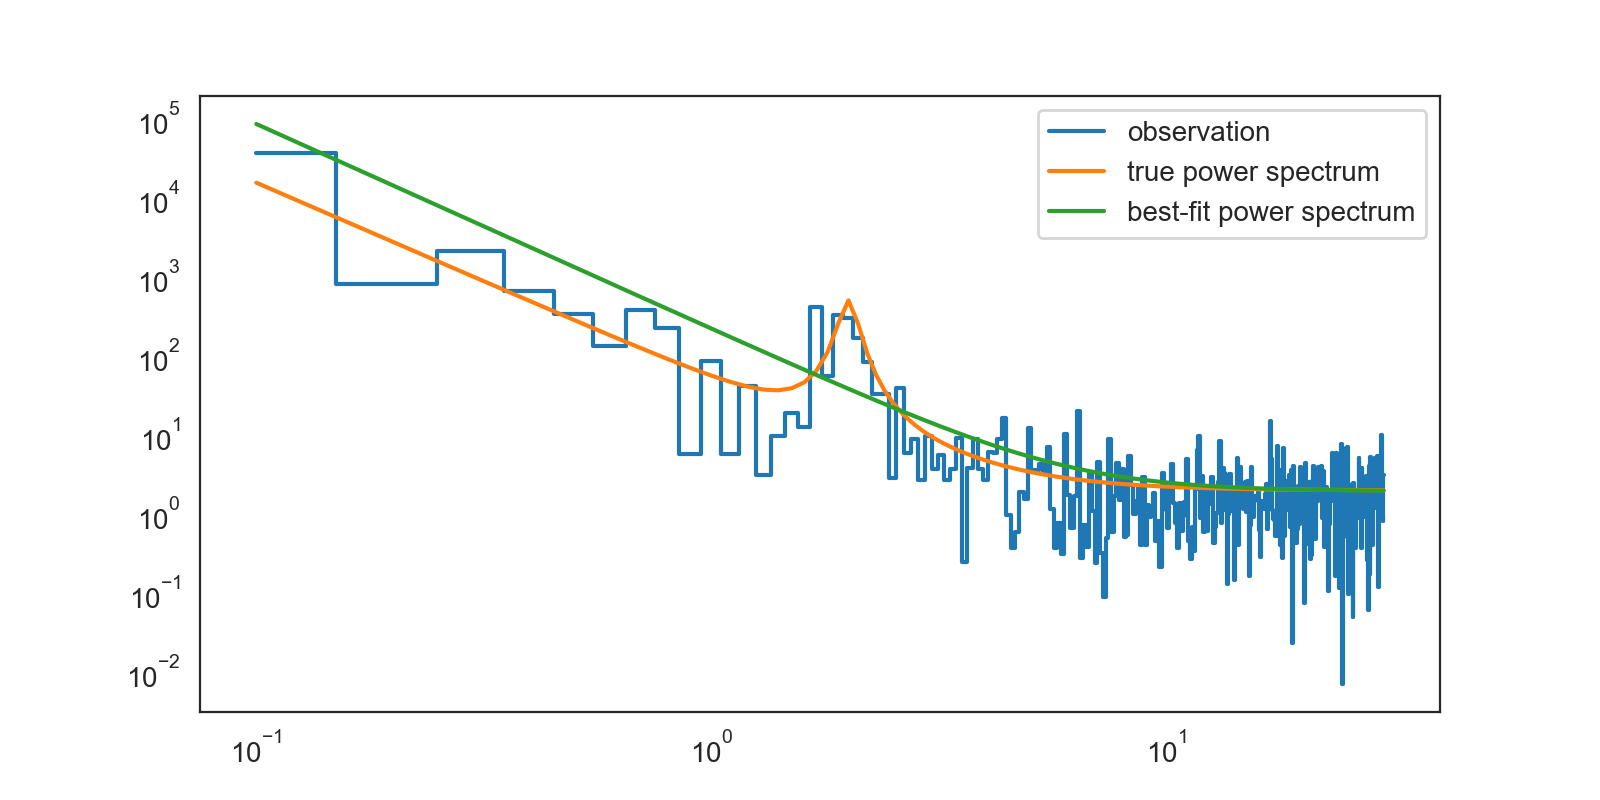

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

Result: It can be noted that the above graph fails as well, but here amplitude is same but f0, width, const is changed. This failure shows that current implementation is failing for all combination of parameters.

<h1> (iii) This shows a room for improvement in the current algorithm and we will investigate the room for improvement in the current implementation by choosing different set of optimizers.

(a) minimize(method = "Nelder-Mead")

In [207]:
test_params = [2.2, 500, 10000, 1.0 , 0.1, 2.1]

loglikelihood(test_params)

DeviceArray(-1580.0679, dtype=float32)

In [208]:
start_pars = [1.0, 40, 1000, 3.0, 0.5, 2.5]

In [209]:
res = scipy.optimize.minimize(objective_function, test_params, method="Nelder-Mead")

In [210]:
res

 final_simplex: (array([[2.72002154e+00, 5.67175373e+01, 5.22981215e+03, 1.93949974e+00,
        2.82104879e-02, 2.13043412e+00],
       [2.72002155e+00, 5.67175375e+01, 5.22981210e+03, 1.93949974e+00,
        2.82104880e-02, 2.13043412e+00],
       [2.72002153e+00, 5.67175379e+01, 5.22981218e+03, 1.93949974e+00,
        2.82104881e-02, 2.13043411e+00],
       [2.72002155e+00, 5.67175374e+01, 5.22981211e+03, 1.93949974e+00,
        2.82104883e-02, 2.13043412e+00],
       [2.72002154e+00, 5.67175374e+01, 5.22981215e+03, 1.93949974e+00,
        2.82104881e-02, 2.13043412e+00],
       [2.72002155e+00, 5.67175376e+01, 5.22981213e+03, 1.93949974e+00,
        2.82104882e-02, 2.13043411e+00],
       [2.72002155e+00, 5.67175369e+01, 5.22981214e+03, 1.93949974e+00,
        2.82104880e-02, 2.13043411e+00]]), array([1346.22937012, 1346.22937012, 1346.22937012, 1346.22937012,
       1346.22937012, 1346.22937012, 1346.22937012]))
           fun: 1346.2293701171875
       message: 'Optimization term

In [211]:
res.x - true_params

array([ 2.20021543e-01,  5.57175373e+01,  4.72981215e+03, -6.05002606e-02,
       -7.17895121e-02,  1.30434116e-01])

In [212]:
(res.x - true_params) / true_params

array([ 8.80086174e-02,  5.57175373e+01,  9.45962430e+00, -3.02501303e-02,
       -7.17895121e-01,  6.52170581e-02])

In [213]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


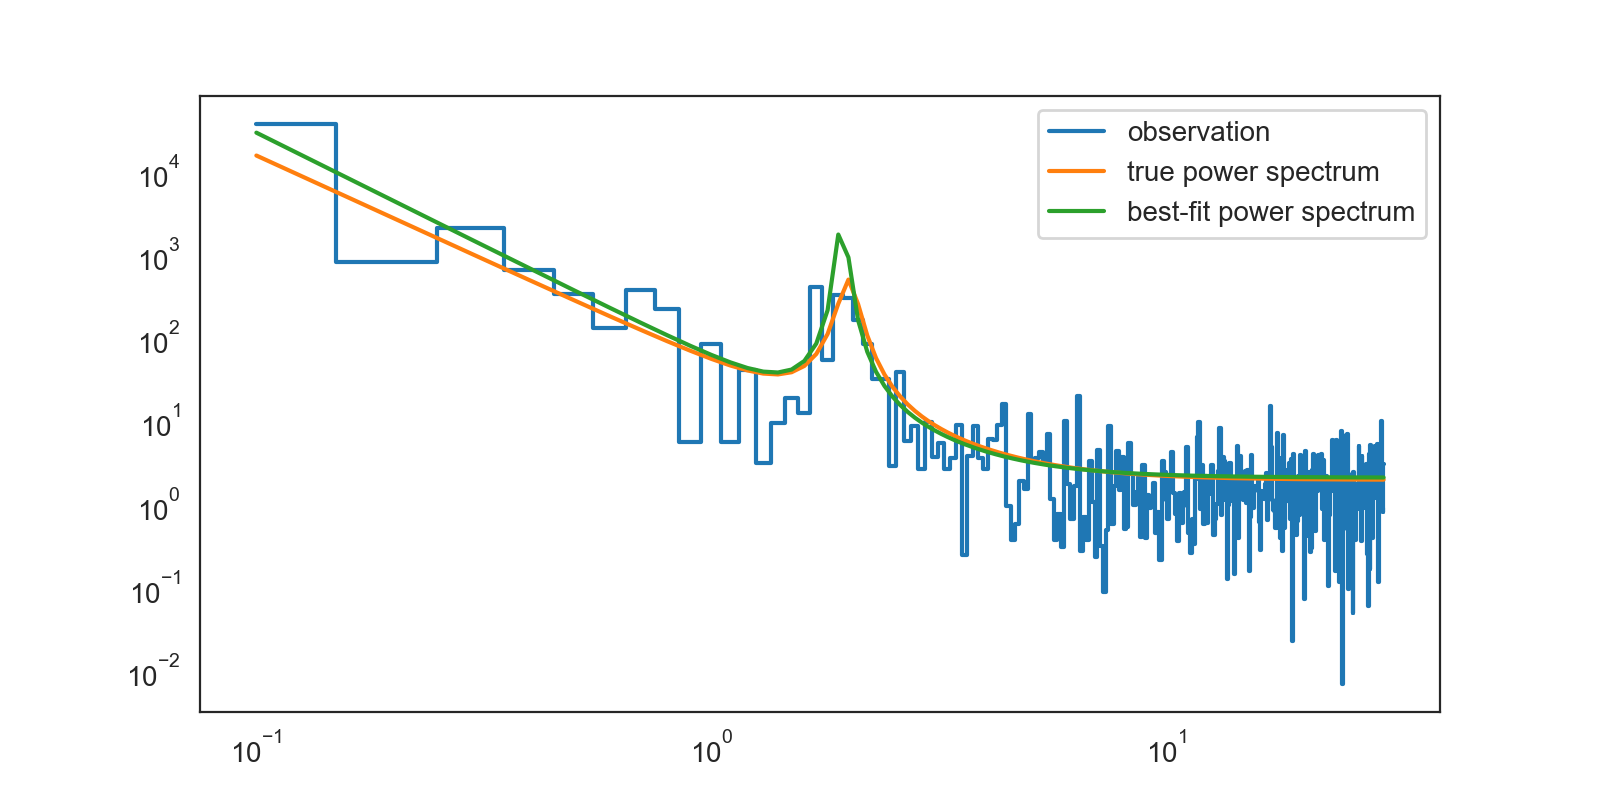

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(b) minimize(method = "CG")

In [215]:
res = scipy.optimize.minimize(objective_function, test_params, method="CG")

In [216]:
res

     fun: 1580.06787109375
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 7
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([2.2e+00, 5.0e+02, 1.0e+04, 1.0e+00, 1.0e-01, 2.1e+00])

In [217]:
res.x - true_params

array([-3.00e-01,  4.99e+02,  9.50e+03, -1.00e+00,  0.00e+00,  1.00e-01])

In [218]:
(res.x - true_params) / true_params

array([-1.20e-01,  4.99e+02,  1.90e+01, -5.00e-01,  0.00e+00,  5.00e-02])

In [219]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


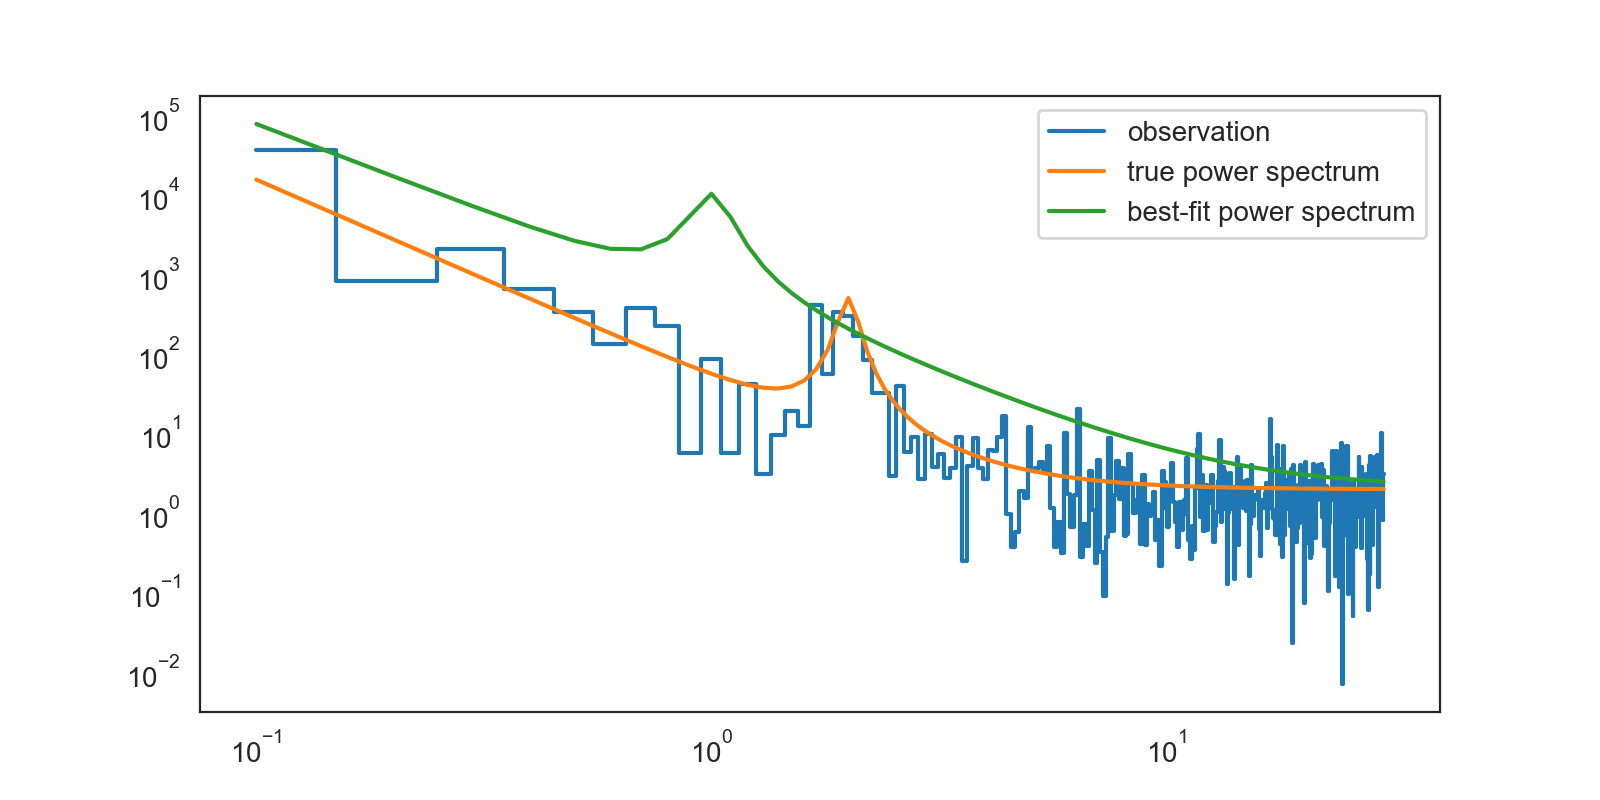

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(c) minimize(method = "BFGS")

In [223]:
res = scipy.optimize.minimize(objective_function, test_params, method="BFGS")

In [224]:
res

      fun: 1580.06787109375
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.2e+00, 5.0e+02, 1.0e+04, 1.0e+00, 1.0e-01, 2.1e+00])

In [225]:
res.x - true_params

array([-3.00e-01,  4.99e+02,  9.50e+03, -1.00e+00,  0.00e+00,  1.00e-01])

In [226]:
(res.x - true_params) / true_params

array([-1.20e-01,  4.99e+02,  1.90e+01, -5.00e-01,  0.00e+00,  5.00e-02])

In [227]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


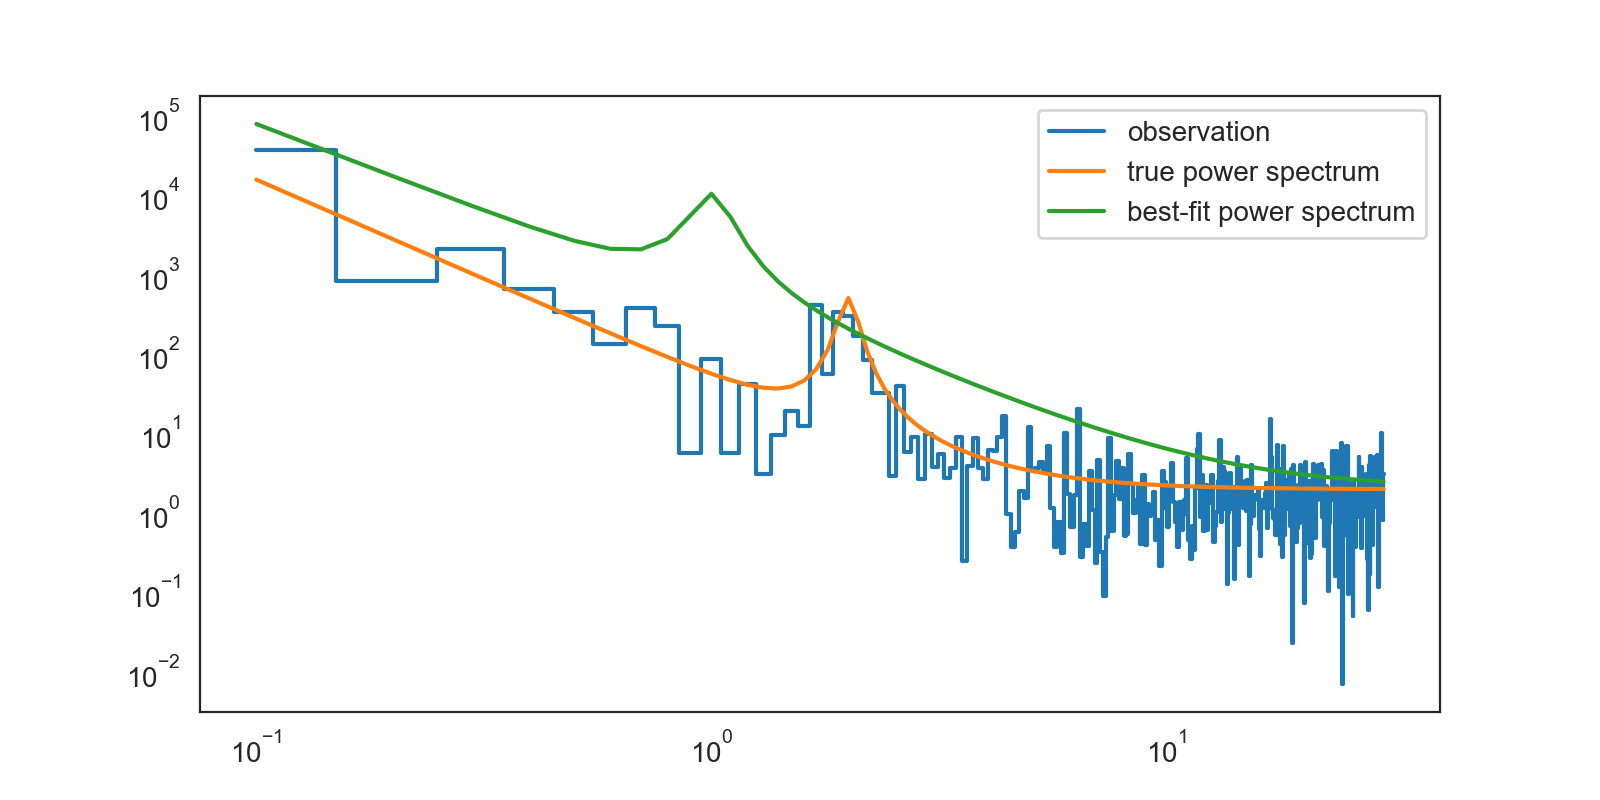

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(d) minimize(method = "L-BFGS-B")

In [229]:
res = scipy.optimize.minimize(objective_function, test_params, method="L-BFGS-B")

In [230]:
res

      fun: DeviceArray(1580.0679, dtype=float32)
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 7
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([2.2e+00, 5.0e+02, 1.0e+04, 1.0e+00, 1.0e-01, 2.1e+00])

In [231]:
res.x - true_params

array([-3.00e-01,  4.99e+02,  9.50e+03, -1.00e+00,  0.00e+00,  1.00e-01])

In [232]:
(res.x - true_params) / true_params

array([-1.20e-01,  4.99e+02,  1.90e+01, -5.00e-01,  0.00e+00,  5.00e-02])

In [233]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


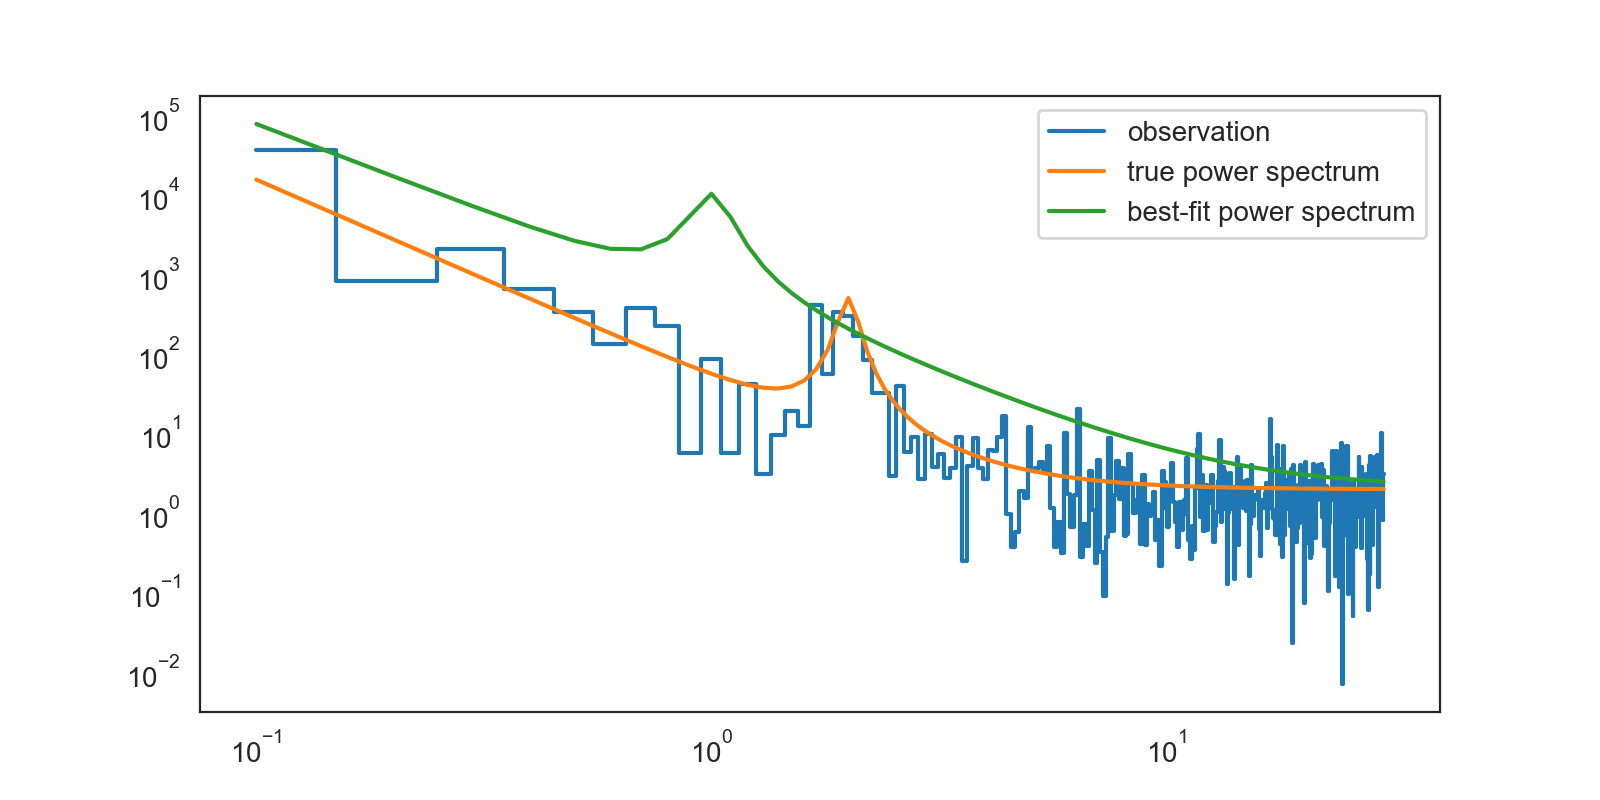

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(e) minimize(method = "TNC")

In [235]:
res = scipy.optimize.minimize(objective_function, test_params, method="TNC")

In [236]:
res

     fun: DeviceArray(1580.0679, dtype=float32)
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 7
     nit: 0
  status: 0
 success: True
       x: array([2.2e+00, 5.0e+02, 1.0e+04, 1.0e+00, 1.0e-01, 2.1e+00])

In [237]:
res.x - true_params

array([-3.00e-01,  4.99e+02,  9.50e+03, -1.00e+00,  0.00e+00,  1.00e-01])

In [238]:
(res.x - true_params) / true_params

array([-1.20e-01,  4.99e+02,  1.90e+01, -5.00e-01,  0.00e+00,  5.00e-02])

In [239]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


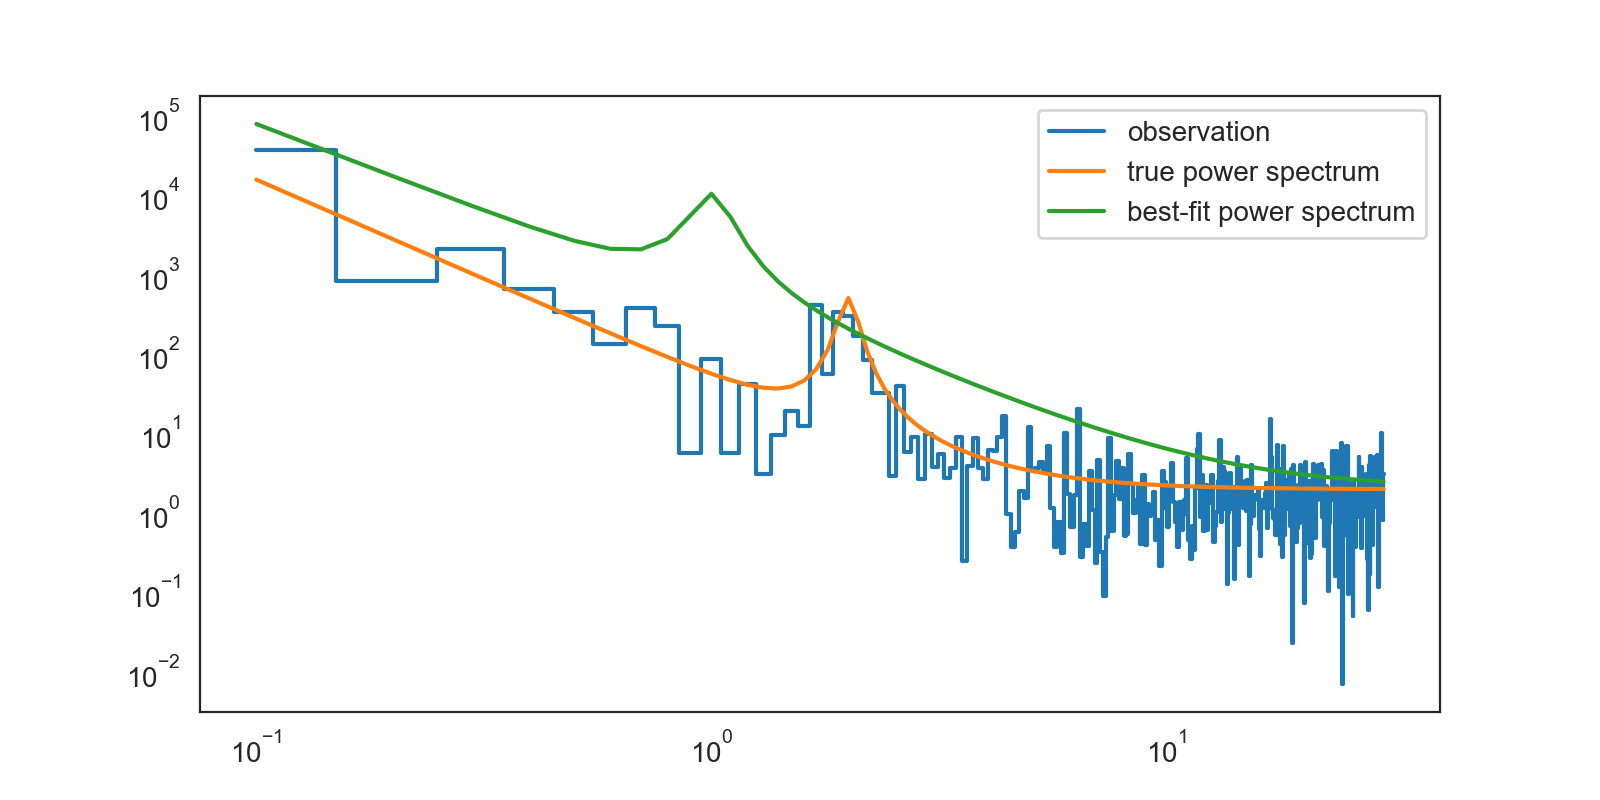

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(f) minimize(method = "COBYLA")

In [241]:
res = scipy.optimize.minimize(objective_function, test_params, method="COBYLA")

In [242]:
res

     fun: 1407.223388671875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 444
  status: 1
 success: True
       x: array([ 3.25537683e+00,  4.99840708e+02,  9.99987799e+03,  8.38491752e-01,
       -4.46765074e-05,  2.01919035e+00])

In [243]:
res.x - true_params

array([ 7.55376830e-01,  4.98840708e+02,  9.49987799e+03, -1.16150825e+00,
       -1.00044677e-01,  1.91903462e-02])

In [244]:
(res.x - true_params) / true_params

array([ 3.02150732e-01,  4.98840708e+02,  1.89997560e+01, -5.80754124e-01,
       -1.00044677e+00,  9.59517311e-03])

In [245]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


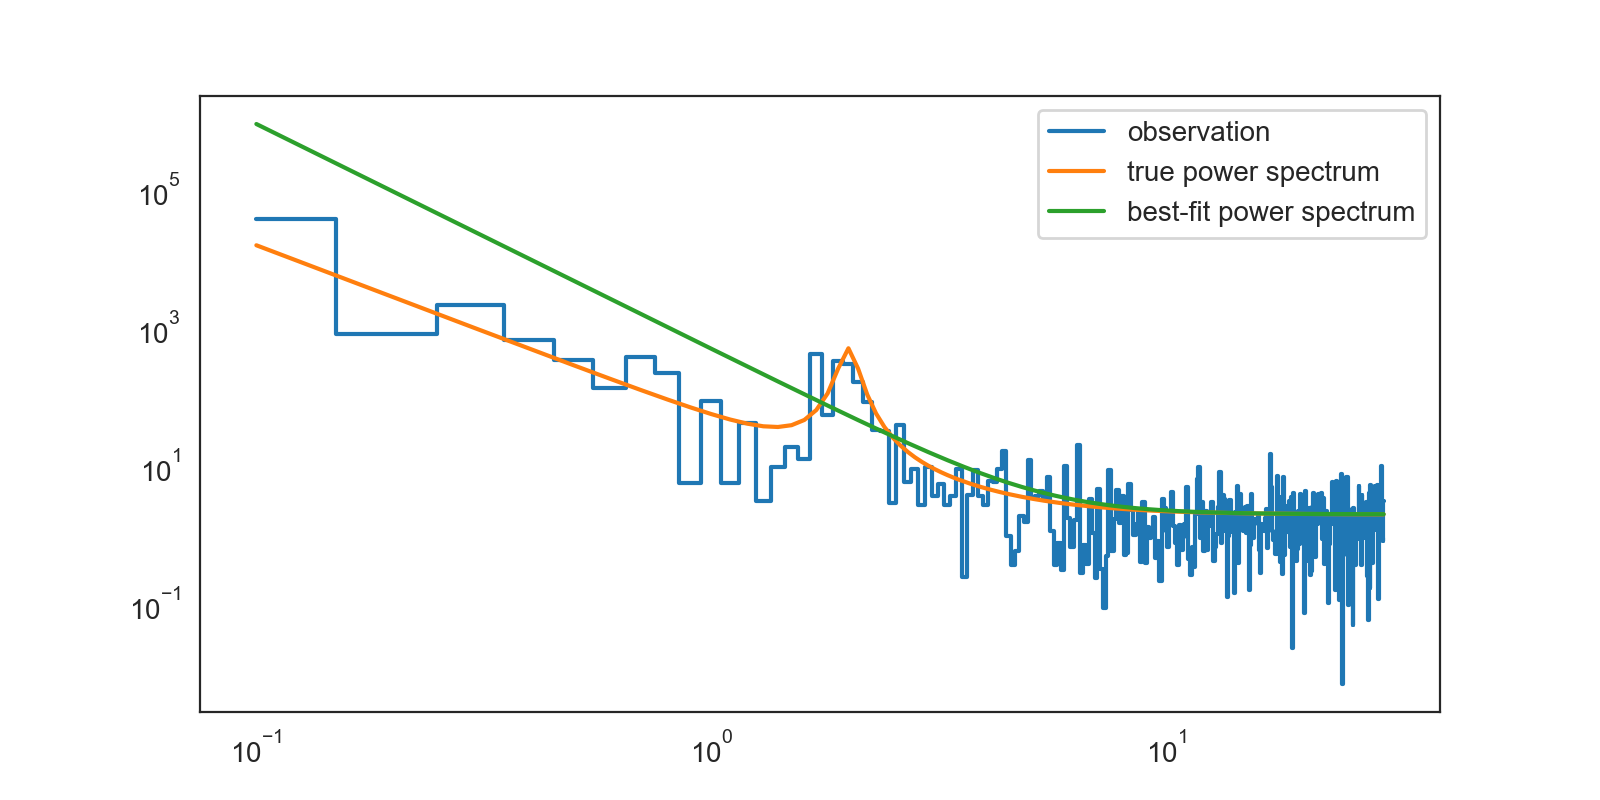

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(f) minimize(method = "SLSQP")

In [247]:
res = scipy.optimize.minimize(objective_function, test_params, method="SLSQP")

In [248]:
res

     fun: 1580.06787109375
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([2.2e+00, 5.0e+02, 1.0e+04, 1.0e+00, 1.0e-01, 2.1e+00])

In [249]:
res.x - true_params

array([-3.00e-01,  4.99e+02,  9.50e+03, -1.00e+00,  0.00e+00,  1.00e-01])

In [250]:
(res.x - true_params) / true_params

array([-1.20e-01,  4.99e+02,  1.90e+01, -5.00e-01,  0.00e+00,  5.00e-02])

In [251]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


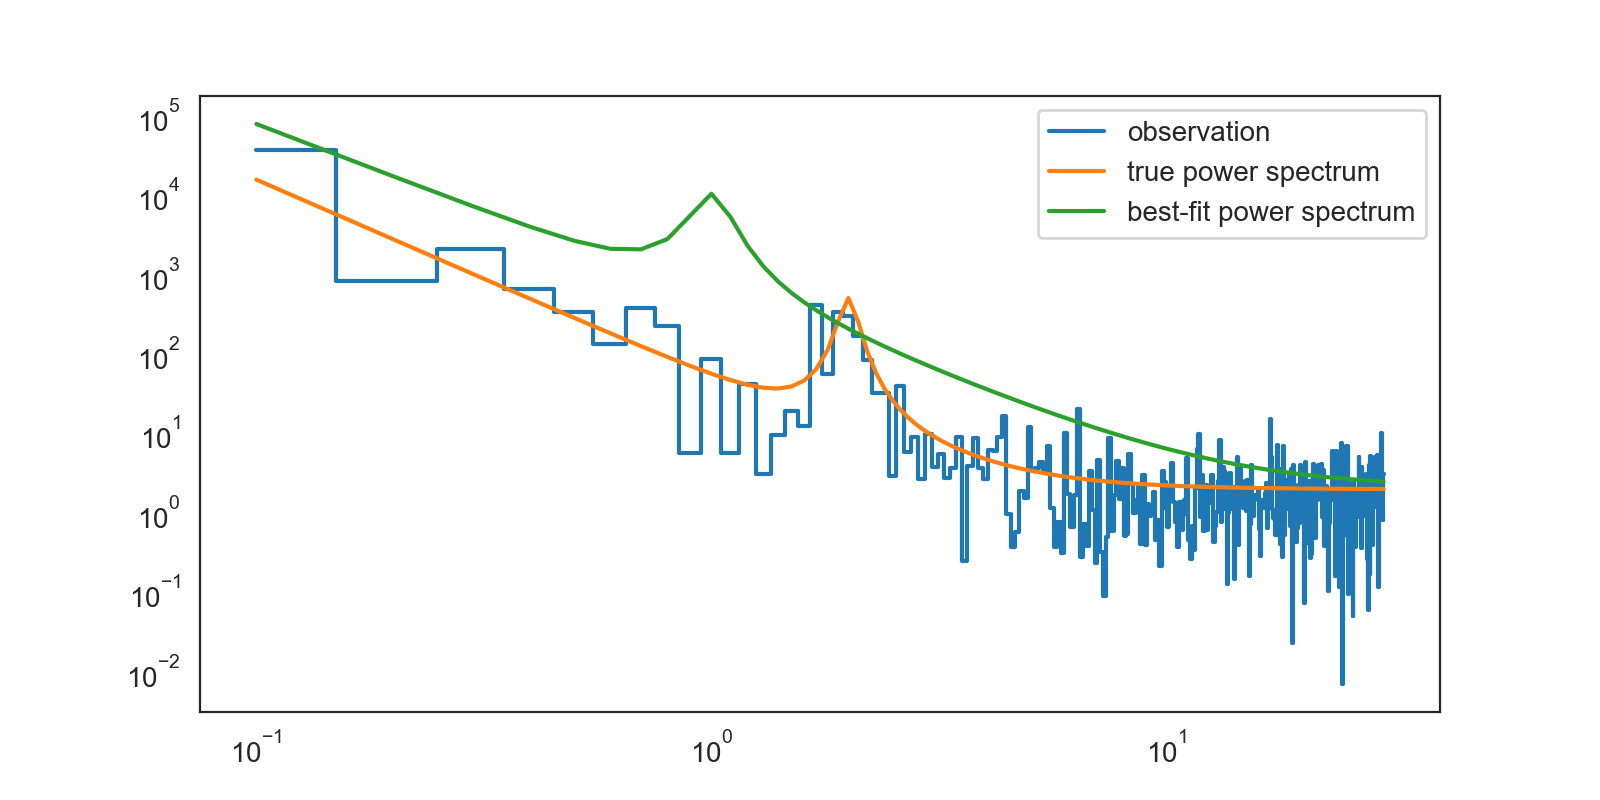

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

(g) minimize(method = "trust-constr")

In [253]:
res = scipy.optimize.minimize(objective_function, test_params, method="trust-constr")

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [254]:
res

         cg_niter: 93
     cg_stop_cond: 2
           constr: []
      constr_nfev: []
      constr_nhev: []
      constr_njev: []
   constr_penalty: 1.0
 constr_violation: 0
   execution_time: 0.5817809104919434
              fun: DeviceArray(1406.9823, dtype=float32)
             grad: array([ 0.        ,  0.04384085,  0.        ,  0.        , 10.96015549,
       -0.17409244])
              jac: []
  lagrangian_grad: array([ 0.        ,  0.04384085,  0.        ,  0.        , 10.96015549,
       -0.17409244])
          message: '`xtol` termination condition is satisfied.'
           method: 'equality_constrained_sqp'
             nfev: 301
             nhev: 0
              nit: 43
            niter: 43
             njev: 43
       optimality: 10.960155487060547
           status: 2
          success: True
        tr_radius: DeviceArray(7.883847e-09, dtype=float32)
                v: []
                x: array([3.19116091e+00, 4.99997389e+02, 1.00000000e+04, 9.45745313e-01,
       7.

In [255]:
res.x - true_params

array([ 6.91160908e-01,  4.98997389e+02,  9.50000002e+03, -1.05425469e+00,
       -9.99922920e-02,  3.08371274e-02])

In [256]:
(res.x - true_params) / true_params

array([ 2.76464363e-01,  4.98997389e+02,  1.90000000e+01, -5.27127343e-01,
       -9.99922920e-01,  1.54185637e-02])

In [257]:
opt_power = model(freq, *res.x)

<IPython.core.display.Javascript object>


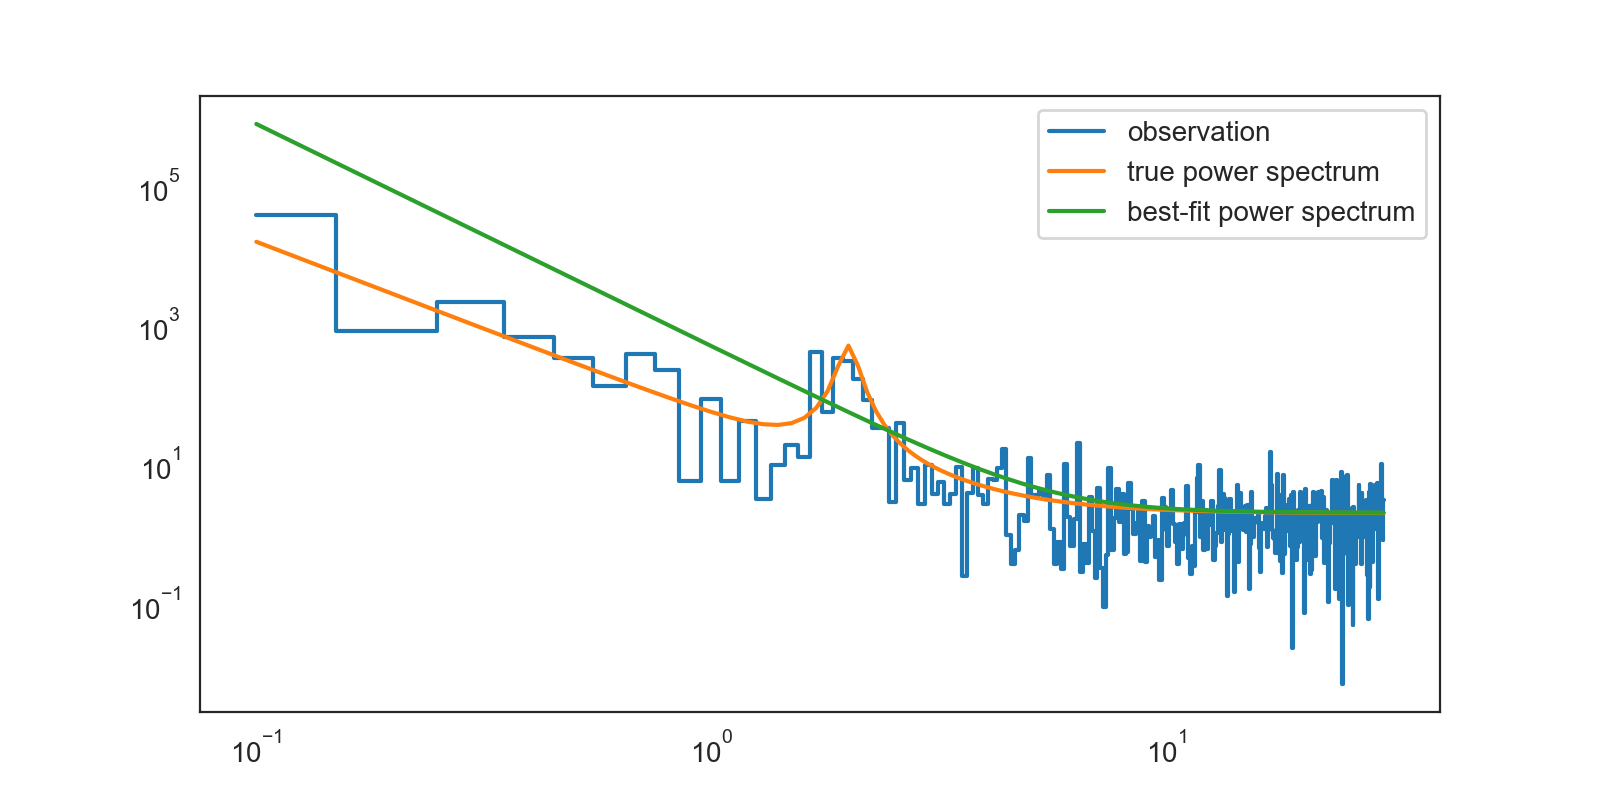

In [258]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.loglog(freq, power, ds="steps-mid", label="observation")
ax.plot(freq, true_power, label="true power spectrum")
ax.plot(freq, opt_power, label="best-fit power spectrum")

ax.legend()

Result: The Nelder-Mead optimizer works as good as Powell as compared to other optimizers above. Another optimizer like dogleg, trust-ncg, might be good as well, but it needs jacobian and hess to be calculated.